In [30]:
#|default_exp conv

In [31]:
#|export
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import default_collate
from typing import Mapping

from fastai_course.training import *
from fastai_course.datasets import *

In [32]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader

In [33]:
mpl.rcParams['image.cmap'] = 'gray'

In [34]:
path_gz = Path('data') / 'mnist.pkl.gz'
path_gz

Path('data/mnist.pkl.gz')

In [35]:
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding='latin-1')

In [36]:
x_train.shape

(50000, 784)

In [37]:
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [38]:
x_train.shape

torch.Size([50000, 784])

In [39]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)

In [40]:
type(x_train)

torch.Tensor

In [41]:
mpl.rcParams['figure.dpi'] = 30

<Axes: >

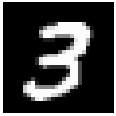

In [42]:
im3 = x_imgs[7]
show_image(im3)

In [43]:
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

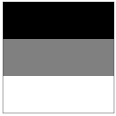

In [15]:
show_image(top_edge, noFrames=False);

In [16]:
# df = pd.DataFrame(im3[:13, :23])
# df.style.format(precision=2).set_properties(**{'font-size': '7pt'}).background_gradient('Greys')

In [17]:
(im3[3:6,14:17] * top_edge).sum()

RuntimeError: The size of tensor a (28) must match the size of tensor b (3) at non-singleton dimension 2

In [ ]:
show_image(im3[7:10,14:17])

In [ ]:
(im3[7:10,14:17] * top_edge).sum()

In [ ]:
def apply_kernel(row, col, kernel):
    return (im3[row - 1: row + 2, col - 1: col+2] * kernel).sum()

In [ ]:
apply_kernel(4, 15, top_edge)

In [ ]:
[[(i, j) for j in range(5)] for i in range(5)]

In [ ]:
rng = range(1, 27)
top_edge_3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge_3);

In [ ]:
show_image(im3)

In [ ]:
left_edge = tensor([[-1, 0, 1],
                   [-1, 0, 0],
                   [-1, 0, 1]]).float()

In [ ]:
rng = range(1, 27)
top_edge_3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(top_edge_3);

In [ ]:
top_edge_3.shape

In [ ]:
im3.shape

In [ ]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

In [ ]:
diag2_edge = tensor([[ 1,-1, 0],
                     [0, 1, -1],
                     [ 1, 0, 1]]).float()

In [27]:
xb = x_imgs[:16][:, None]
xb.shape

torch.Size([16, 1, 1, 28, 28])

In [ ]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

In [ ]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

In [ ]:
img0 = xb[1, 0]
show_image(img0);

In [ ]:
show_images([batch_features[1, i] for i in range(4)])

In [44]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50
n, m, nh

(50000, 784, 50)

In [45]:
model = nn.Sequential(
    nn.Linear(m, nh),
    nn.ReLU(),
    nn.Linear(nh, 10)
)

In [46]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [47]:
xb.shape

torch.Size([16, 1, 1, 28, 28])

In [29]:
cnn_1 = conv(1, 4)
cnn_1(xb).shape

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [16, 1, 1, 28, 28]

In [21]:
simple_cnn = nn.Sequential(
    conv(1, 4),  # 14 * 14
    conv(4, 8),  # 7 * 7
    conv(8, 16), # 4 * 4
    conv(16, 16), # 2 * 2
    conv(16, 10, act=False),
    nn.Flatten()
)

In [22]:
simple_cnn(xb).shape

NameError: name 'xb' is not defined

In [48]:
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [49]:
#|export
def_device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k: v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b):
    return to_device(default_collate(b))

In [50]:
def_device

'mps'

In [51]:
default_collate(
    [torch.randn(2, 3),
    torch.randn(2, 3)]
).shape

torch.Size([2, 2, 3])

In [52]:
from torch import optim
bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [53]:
for images in train_dl:
    print(images[0].shape)
    break

torch.Size([256, 1, 28, 28])


In [54]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 1.2814342966079713 0.5299999999046325
1 0.4122254180908203 0.8766000005722046
2 0.4571179659843445 0.8535000003814698
3 0.1633616235256195 0.9501999995231628
4 0.11921571159362793 0.9663999993324279


In [55]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.09139792792797088 0.9738999995231629
1 0.10102200527191162 0.9688999997138977
2 0.08959267249107361 0.9733999996185303
3 0.08775298755168914 0.9748999996185302
4 0.08892365155220032 0.9747999996185303


In [56]:
import nbdev; nbdev.nbdev_export()